In [1]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x)
train_y = Variable(torch.sin(((train_x.data[:, 0] + train_x.data[:, 1]) * (2 * math.pi))))

In [3]:
class LatentFunction(gpytorch.GridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=20, grid_bounds=[(0, 1), (0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPRegressionModel(gpytorch.GPModel):
    def __init__(self):
        super(GPRegressionModel,self).__init__(GaussianLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)
    
model = GPRegressionModel()

In [4]:
def plot_model_and_predictions(model):
    n = 10
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)

    observed_pred = model(test_x)
    pred_labels = observed_pred.mean().view(n, n).data.numpy()
    
    test_y_actual = torch.sin(((test_x.data[:, 0] + test_x.data[:, 1]) * (2 * math.pi))).numpy().reshape(n, n)
    delta_y = numpy.absolute(pred_labels - test_y_actual)
    
    def ax_plot(f, ax, y_labels, title):
        im = ax.imshow(y_labels)
        ax.set_title(title)
        f.colorbar(im)
    
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')
    
    f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

    f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')
    
    return f

In [5]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(60):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/60 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

Iter 1/60 - Loss: 1.078
Iter 2/60 - Loss: 1.029
Iter 3/60 - Loss: 0.984
Iter 4/60 - Loss: 0.935
Iter 5/60 - Loss: 0.883
Iter 6/60 - Loss: 0.834
Iter 7/60 - Loss: 0.781
Iter 8/60 - Loss: 0.715
Iter 9/60 - Loss: 0.646
Iter 10/60 - Loss: 0.570
Iter 11/60 - Loss: 0.505
Iter 12/60 - Loss: 0.439
Iter 13/60 - Loss: 0.374
Iter 14/60 - Loss: 0.312
Iter 15/60 - Loss: 0.260
Iter 16/60 - Loss: 0.205
Iter 17/60 - Loss: 0.156
Iter 18/60 - Loss: 0.110
Iter 19/60 - Loss: 0.068
Iter 20/60 - Loss: 0.017
Iter 21/60 - Loss: -0.031
Iter 22/60 - Loss: -0.081
Iter 23/60 - Loss: -0.122
Iter 24/60 - Loss: -0.165
Iter 25/60 - Loss: -0.195
Iter 26/60 - Loss: -0.239
Iter 27/60 - Loss: -0.258
Iter 28/60 - Loss: -0.258
Iter 29/60 - Loss: -0.281
Iter 30/60 - Loss: -0.278
Iter 31/60 - Loss: -0.282
Iter 32/60 - Loss: -0.286
Iter 33/60 - Loss: -0.286
Iter 34/60 - Loss: -0.239
Iter 35/60 - Loss: -0.226
Iter 36/60 - Loss: -0.209
Iter 37/60 - Loss: -0.167
Iter 38/60 - Loss: -0.203
Iter 39/60 - Loss: -0.144
Iter 40/60 - Lo

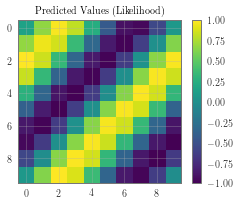

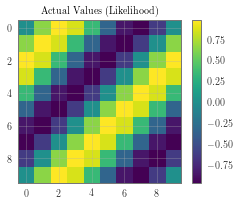

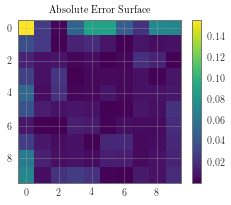

In [6]:
model.condition(train_x, train_y)
f = plot_model_and_predictions(model)